In [75]:
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

root_dir = 'path/to/celeba/dataset'

# Define the transformation. You might want to transform the images (e.g., resizing, normalization) for your specific task.
transform = transforms.Compose([
    transforms.Resize((200, 160)),
    transforms.ToTensor(), # Convert images to tensor
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize images
])


celeba_dataset = CelebA(root=root_dir, split='train', transform=transform, download=True)


Files already downloaded and verified


In [3]:
len(celeba_dataset)

162770

In [79]:
import torch
import torch.nn as nn

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # Input channels = 3 (RGB), Output channels = 16
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7) # No padding
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Using Sigmoid to ensure the output is between 0 and 1
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [98]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model instantiation
model = CNNAutoencoder().to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
num_epochs = 1

total_data = len(celeba_dataset)

batch_size = 1

# Create a DataLoader
data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)



In [122]:

import torch.nn.functional as F
# from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage
from facenet_pytorch import MTCNN

mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

def tensor_to_img(t):
    img_tensor = (t * 255).byte()
    to_pil_image = ToPILImage()
    img = to_pil_image(img_tensor)

    return img
    
def scale_outside_bbox(tensor, bbox, scale_factor):
    C, H, W = tensor.shape
    x_min, y_min, x_max, y_max = map(int, bbox)
    
    mask = torch.full_like(tensor, scale_factor)
    mask[:, y_min:y_max, x_min:x_max] = 1

    tensor_masked = tensor * mask
    
    return tensor_masked

def objective(source, reconstruction):
    img = tensor_to_img(source)
    boxes, probs = mtcnn.detect(img)

    assert boxes is not None, "no face found"

    bbox = boxes[0]
    
    scaled_source = scale_outside_bbox(source, bbox, 0.2)
    scaled_reconstruction = scale_outside_bbox(reconstruction, bbox, 0.1)

    loss = F.mse_loss(scaled_source, scaled_reconstruction)
    
    return loss



In [123]:
# Training loop
for epoch in range(num_epochs):
    for i, data in tqdm(enumerate(data_loader), total=total_data / batch_size):
        img, _ = data
        img = img.to(device)
        
        # Forward pass
        outputs = model(img)

        # loss = criterion(outputs, img)
        loss = objective(img[0], outputs[0])
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i % 25:
            print(f'Batch {i}, Loss: {loss.item():.4f}')
        
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  0%|          | 2/162770.0 [00:00<3:20:17, 13.54it/s]

Batch 0, Loss: 0.0112


  0%|          | 27/162770.0 [00:03<6:18:40,  7.16it/s]

Batch 25, Loss: 0.0130


  0%|          | 52/162770.0 [00:07<6:32:39,  6.91it/s]

Batch 50, Loss: 0.0074


  0%|          | 76/162770.0 [00:11<9:53:10,  4.57it/s] 

Batch 75, Loss: 0.0117


  0%|          | 101/162770.0 [00:14<4:27:19, 10.14it/s]

Batch 100, Loss: 0.0042


  0%|          | 127/162770.0 [00:19<9:02:43,  4.99it/s] 

Batch 125, Loss: 0.0035


  0%|          | 152/162770.0 [00:25<9:10:31,  4.92it/s] 

Batch 150, Loss: 0.0051


  0%|          | 176/162770.0 [00:29<6:55:25,  6.52it/s]

Batch 175, Loss: 0.0041


  0%|          | 202/162770.0 [00:33<7:35:47,  5.94it/s]

Batch 200, Loss: 0.0066


  0%|          | 227/162770.0 [00:38<7:20:52,  6.14it/s] 

Batch 225, Loss: 0.0086


  0%|          | 251/162770.0 [00:43<8:46:21,  5.15it/s] 

Batch 250, Loss: 0.0023


  0%|          | 277/162770.0 [00:47<6:41:02,  6.75it/s]

Batch 275, Loss: 0.0053


  0%|          | 302/162770.0 [00:53<8:54:19,  5.07it/s] 

Batch 300, Loss: 0.0036


  0%|          | 327/162770.0 [00:57<6:09:08,  7.33it/s] 

Batch 325, Loss: 0.0048


  0%|          | 352/162770.0 [01:01<7:12:49,  6.25it/s]

Batch 350, Loss: 0.0067


  0%|          | 377/162770.0 [01:06<10:07:05,  4.46it/s]

Batch 375, Loss: 0.0052


  0%|          | 402/162770.0 [01:10<7:14:22,  6.23it/s] 

Batch 400, Loss: 0.0018


  0%|          | 426/162770.0 [01:15<7:47:22,  5.79it/s] 

Batch 425, Loss: 0.0037


  0%|          | 452/162770.0 [01:21<9:28:20,  4.76it/s] 

Batch 450, Loss: 0.0047


  0%|          | 477/162770.0 [01:26<9:25:49,  4.78it/s] 

Batch 475, Loss: 0.0015


  0%|          | 501/162770.0 [01:32<8:35:28,  5.25it/s] 

Batch 500, Loss: 0.0034


  0%|          | 527/162770.0 [01:37<7:07:23,  6.33it/s] 

Batch 525, Loss: 0.0022


  0%|          | 552/162770.0 [01:42<7:59:04,  5.64it/s] 

Batch 550, Loss: 0.0140


  0%|          | 577/162770.0 [01:47<6:39:58,  6.76it/s]

Batch 575, Loss: 0.0040


  0%|          | 602/162770.0 [01:52<9:48:08,  4.60it/s] 

Batch 600, Loss: 0.0019


  0%|          | 627/162770.0 [01:57<7:35:58,  5.93it/s] 

Batch 625, Loss: 0.0031


  0%|          | 652/162770.0 [02:02<7:57:45,  5.66it/s] 

Batch 650, Loss: 0.0016


  0%|          | 677/162770.0 [02:06<6:24:45,  7.02it/s]

Batch 675, Loss: 0.0049


  0%|          | 702/162770.0 [02:10<8:10:30,  5.51it/s]

Batch 700, Loss: 0.0043


  0%|          | 726/162770.0 [02:15<8:47:06,  5.12it/s] 

Batch 725, Loss: 0.0049


  0%|          | 741/162770.0 [02:18<8:22:59,  5.37it/s] 


AssertionError: no face found

In [118]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Assuming img is a PyTorch tensor of shape (C, H, W)
    img = img.detach().numpy()  # Convert to numpy array
    plt.figure(figsize=(5, 5))  # Adjust display size as needed
    # Transpose the image dimensions from (C, H, W) to (H, W, C) for plotting
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')  # Hide axes ticks
    plt.show()

In [137]:
images, _ = next(iter(data_loader))

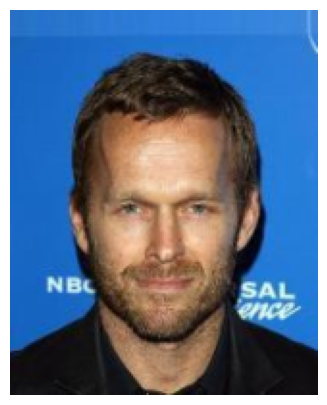

In [138]:
imshow(images[0])

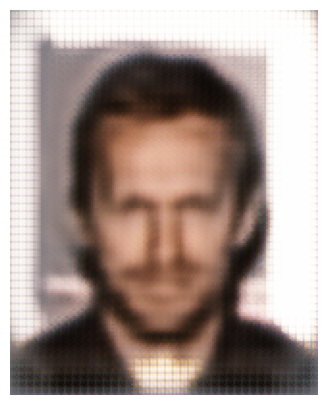

In [139]:
reconstruction = model(images[0])
reconstruction.detach()
imshow(reconstruction)

In [50]:
images[0]

tensor([[[ 0.7725,  0.8353,  0.8510,  ...,  0.5059,  0.4980,  0.5373],
         [ 0.7647,  0.8353,  0.8039,  ...,  0.4980,  0.4980,  0.5529],
         [ 0.7255,  0.7725,  0.6392,  ...,  0.4980,  0.5059,  0.5529],
         ...,
         [ 0.3176,  0.2784,  0.3333,  ...,  0.4510,  0.5294,  0.3569],
         [ 0.4431,  0.3804,  0.4039,  ...,  0.4667,  0.5373,  0.5059],
         [ 0.3490,  0.4353,  0.5529,  ...,  0.4980,  0.5294,  0.5216]],

        [[ 0.3725,  0.3961,  0.4588,  ...,  0.4588,  0.4353,  0.4667],
         [ 0.3569,  0.3882,  0.3882,  ...,  0.4510,  0.4353,  0.4902],
         [ 0.3412,  0.3333,  0.2314,  ...,  0.4588,  0.4431,  0.4902],
         ...,
         [-0.0431, -0.1216, -0.0980,  ...,  0.1137,  0.1529,  0.0353],
         [ 0.0431, -0.0588, -0.0745,  ...,  0.0745,  0.1059,  0.0980],
         [-0.1294, -0.0745,  0.0118,  ...,  0.0588,  0.0667,  0.0353]],

        [[-0.0588,  0.0118,  0.1765,  ...,  0.4431,  0.4039,  0.4118],
         [-0.0667,  0.0118,  0.0902,  ...,  0

In [51]:
reconstruction

tensor([[[0.4921, 0.4968, 0.4919,  ..., 0.4968, 0.4920, 0.4930],
         [0.4905, 0.4877, 0.4909,  ..., 0.4876, 0.4909, 0.4851],
         [0.4924, 0.4968, 0.4917,  ..., 0.4969, 0.4915, 0.4930],
         ...,
         [0.4905, 0.4879, 0.4909,  ..., 0.4878, 0.4909, 0.4852],
         [0.4925, 0.4966, 0.4909,  ..., 0.4968, 0.4916, 0.4931],
         [0.4898, 0.4873, 0.4897,  ..., 0.4870, 0.4896, 0.4904]],

        [[0.4758, 0.4836, 0.4756,  ..., 0.4840, 0.4758, 0.4792],
         [0.4828, 0.4791, 0.4834,  ..., 0.4788, 0.4836, 0.4786],
         [0.4758, 0.4841, 0.4757,  ..., 0.4840, 0.4757, 0.4787],
         ...,
         [0.4827, 0.4793, 0.4837,  ..., 0.4791, 0.4834, 0.4784],
         [0.4758, 0.4843, 0.4758,  ..., 0.4839, 0.4758, 0.4788],
         [0.4774, 0.4779, 0.4776,  ..., 0.4780, 0.4774, 0.4771]],

        [[0.5283, 0.5385, 0.5283,  ..., 0.5387, 0.5283, 0.5310],
         [0.5295, 0.5261, 0.5299,  ..., 0.5259, 0.5301, 0.5245],
         [0.5282, 0.5387, 0.5286,  ..., 0.5387, 0.5288, 0.